## Part 4: Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the `MAILOUT` data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The `MAILOUT` data has been split into two approximately equal parts, each with almost 43 000 data rows. The `TRAIN` dataset includes a target column `RESPONSE`, that states whether or not a person became a customer of the company following the campaign. We'll train and validate on that dataset. Then we'll make predictions on the `TEST` dataset, where the `RESPONSE` column has been withheld.

In [1]:
# setting random state for reproducibility
random_state = 22

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RepeatedStratifiedKFold

# from sklearn.preprocessing import StandardScaler

# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# from sklearn.tree import DecisionTreeClassifier

In [2]:
df_train = pd.read_csv('data/clean_TRAIN.csv', low_memory=False)
del df_train['Unnamed: 0']

In [3]:
df_train.shape

(42962, 310)

In [4]:
df_train.head()

,AGER_TYP,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_MAINSTREAM
0,2,1.0,15.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,...,2.0,1.0,6.0,9.0,3.0,3,0,0,4,1
1,1,4.0,1.0,0.0,0.0,2.0,0.0,2.0,5.0,5.0,...,2.0,1.0,4.0,9.0,7.0,1,0,0,3,1
2,1,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,...,4.0,2.0,-1.0,9.0,2.0,3,0,1,4,0
3,2,1.0,4.0,0.0,0.0,2.0,0.0,4.0,2.0,2.0,...,11.0,11.0,6.0,9.0,1.0,3,0,0,4,0
4,2,1.0,53.0,0.0,0.0,1.0,0.0,3.0,4.0,7.0,...,2.0,1.0,6.0,9.0,3.0,3,0,1,3,1


Let's check how the target variable is balanced on the dataset.

0    42430
1      532
Name: RESPONSE, dtype: int64


Response = 1.25 %


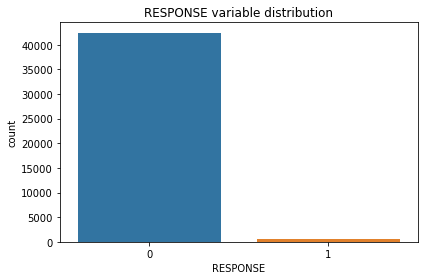

In [5]:
# check RESPONSE variable balance 
print(df_train.RESPONSE.value_counts())
print('\n')
print('Response =', round(((df_train.loc[df_train.RESPONSE == 1].shape[0])/(df_train.loc[df_train.RESPONSE == 0].shape[0])*100),2),'%')

# plot countplot
fig, ax = plt.subplots()
sns.countplot(x=df_train.RESPONSE, ax=ax)
ax.set_title('RESPONSE variable distribution')
ax.set_xlabel('RESPONSE')
plt.tight_layout()

As we can see from the plot, we've got a **HIGHLY INBALANCED** dataset on the target variable.

This will certainly be a challenge for our task! Let's get to it!

#### Metrics Selection

Before we get our hands on modeling, let's determine which metrics we'll be using to evaluate the model afterwards.

It's important to have this step previously to building the model so we don't get biased by the results.

**Accuracy**:

For this task, with a highly imbalanced dataset as we've stated, it definitelly doesn't make sense to use `accuracy` to evaluate our model. The accuracy score is the fraction of correct predictions. In imbalanced datasets, accuracy will be close to 100% even if we were to predict all data points to 0 (dummy classifier).

**Precision, Recall and F-measures**:

    TP (true positives) - Positive predicted as positive (correct prediction)
    TN (true negatives) - Negative predicted as negative (correct prediction)
    FN (false negatives) - Positive predicted as negative (incorrect prediction)
    FP (false positives) - Negative predicted as positive (incorrect prediction)

Precision: out of all positive predictions (TP + FP), how many were predicted correctly (TP)?

    TP / (TP + FP)

Recall: out of all actual positive samples (TP + FN), how many were predicted correctly (TP)?

    TP / (TP + FN)

F1 Score is the harmonic mean of precision and recall, so it's a good metric to evaluate a model like ours.


**Area Under the ROC curve (AUC)**:

The ROC (Receiver operating characteristic) curve is a plot of the true positive rate (TPR = fraction of TP out of the positives or sensitivity) vs. the false positive rate (FPR = fraction of false positives out of the negatives or specificity) as the threshold varies. 

So the closer to 1 the area under the ROC curve is, the closer the sensitivity and specificity are to the sweet spot.


**-> In this case, we want to keep a close eye for F1 score and also AUC score.**

#### Modeling

We'll use `pycaret` to run several models so we can choose from.

As preprocessing steps, we'll adopt:
- normalization of data with z-score:

    the mean is 0 and the standard deviation is 1
    
- balancing of target variable with Synthetic Minority Oversampling Technique, or `SMOTE` method:

    it creates synthetic examples for the minority class.

In [11]:
# setting up pycaret with normalization and imbalance handling
s = setup(df_train, target = 'RESPONSE',
          normalize = True,
          fix_imbalance = True)

,Description,Value
0,session_id,4754
1,Target,RESPONSE
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(42962, 310)"
5,Missing Values,False
6,Numeric Features,221
7,Categorical Features,88
8,Ordinal Features,False
9,High Cardinality Features,False


In [12]:
# run models to compare
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9873,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7620
rf,Random Forest Classifier,0.9383,0.5511,0.0520,0.0194,0.0266,0.0074,0.0060,10.9430
et,Extra Trees Classifier,0.9383,0.5390,0.0520,0.0194,0.0266,0.0074,0.0060,11.7160
lightgbm,Light Gradient Boosting Machine,0.9317,0.5449,0.0626,0.0198,0.0280,0.0081,0.0074,9.5460
gbc,Gradient Boosting Classifier,0.9244,0.5484,0.0678,0.0196,0.0283,0.0078,0.0067,71.0140
ada,Ada Boost Classifier,0.9219,0.5341,0.0470,0.0169,0.0149,0.0004,-0.0029,15.0210
dt,Decision Tree Classifier,0.9218,0.5017,0.0728,0.0159,0.0255,0.0046,0.0046,3.8080
qda,Quadratic Discriminant Analysis,0.8386,0.4917,0.1358,0.0115,0.0211,-0.0024,-0.0050,14.0850
lr,Logistic Regression,0.7673,0.5402,0.2819,0.0159,0.0300,0.0061,0.0150,31.1660
svm,SVM - Linear Kernel,0.7572,0.0000,0.2767,0.0155,0.0292,0.0052,0.0116,4.5560


As I had said before, the accuracy is very high for the dummy classifier, as well as for the other top 6 models because of how imbalanced the dataset is on the target feature.

Unfortunatelly, the F1 score and AUC metrics did not perform as we would want them to.

#### Chosen model

I'm gonna go ahead with the `Random Forest Classifier` model because it has the highest AUC score.

The `balanced` mode passed to `class_weight` uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as:

    n_samples / (n_classes * np.bincount(y))

In [70]:
# train random forest model
rf = create_model('rf',
                  class_weight = 'balanced',
                  random_state = random_state)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8920,0.4709,0.0513,0.0069,0.0122,-0.0109,-0.0175
1,0.9664,0.6076,0.1026,0.0571,0.0734,0.0577,0.0603
2,0.9186,0.5721,0.0769,0.0142,0.0239,0.0020,0.0029
3,0.9149,0.5633,0.0000,0.0000,0.0000,-0.0220,-0.0316
4,0.9707,0.6079,0.0789,0.0536,0.0638,0.0495,0.0505
5,0.9641,0.5436,0.0263,0.0139,0.0182,0.0017,0.0018
6,0.9342,0.5179,0.0000,0.0000,0.0000,-0.0208,-0.0268
7,0.9385,0.5498,0.0789,0.0196,0.0314,0.0114,0.0144
8,0.9657,0.4874,0.0263,0.0149,0.0190,0.0030,0.0031


In [71]:
evaluate_model(rf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


#### Evaluating model

Let's make some plots so we can better understand the model performance.

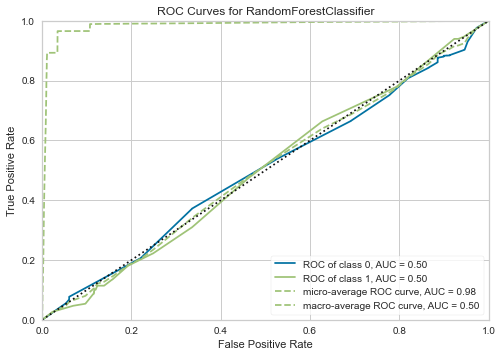

In [72]:
# plot auc
plot_model(rf, plot = 'auc')

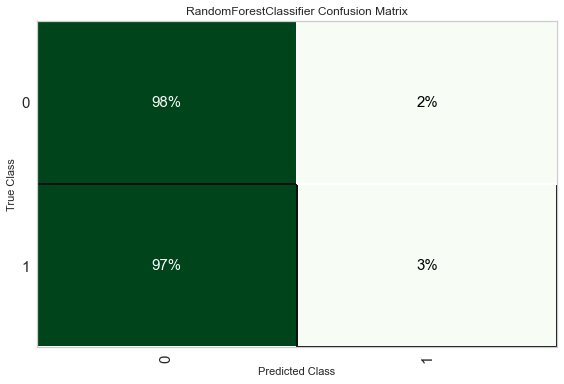

In [73]:
# plot confusion matrix
plot_model(rf, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

Because the target variable is highly imbalanced, even though we addressed it with the `SMOTE` method before training the model, it still isn't exactly "real data" so it's hard to have the model behave well under this circumstance.

The accuracy is high for the majority class (98%) and very low for the minority class (3%), this is caused by a lack of representation of the minority class.

The issue we face here is exactly that we have too many FN - False Negatives (ositive predicted wrongly as negative) which means that for individuals who actually responded to the campaing, our model predicted that they wouldn't respond.

That would make us miss the chance of acquiring that customer because he wouln't be on the marketing target (wrongly).

#### Make predictions

Now it's time to make predictions on the `test` dataset!!

We won't be able to evaluate our predictions because the test dataset doesn't have the target column.

Let's do it!

In [58]:
df_test = pd.read_csv('data/clean_TEST.csv', low_memory=False)
del df_test['Unnamed: 0']

In [59]:
df_test.shape

(42833, 309)

In [63]:
# make predicted dataset
df_predicted = predict_model(rf, data = df_test)
df_predicted.head()

,AGER_TYP,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_MAINSTREAM,Label,Score
0,2,1.0,2.0,0.0,0.0,2.0,0.0,3.0,6.0,2.0,...,3.0,6.0,9.0,3.0,3,1,4,0,0,0.94
1,-1,1.0,20.0,0.0,0.0,1.0,0.0,4.0,7.0,5.0,...,1.0,6.0,9.0,5.0,3,1,4,1,0,0.97
2,2,9.0,2.0,0.0,0.0,4.0,0.0,4.0,1.0,7.0,...,3.0,2.0,9.0,4.0,3,0,4,0,0,0.96
3,-1,7.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,...,3.0,-1.0,9.0,2.0,3,0,4,1,0,0.95
4,1,1.0,1.0,0.0,0.0,4.0,0.0,3.0,6.0,5.0,...,3.0,3.0,9.0,7.0,4,0,4,1,0,0.92


In [64]:
df_predicted.shape

(42833, 311)

There we go, we've made predictions on the test dataset!

Let's check how the label variable is distributed on the predicted dataset.

0    41941
1      892
Name: Label, dtype: int64


Response = 2.13 %


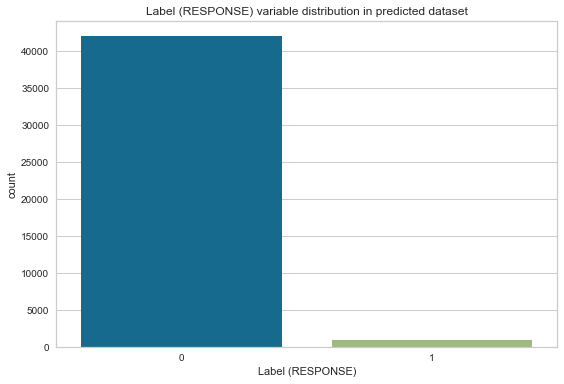

In [66]:
# check target variable balance in predicted dataset
print(df_predicted.Label.value_counts())
print('\n')
print('Response =', round(((df_predicted.loc[df_predicted.Label == 1].shape[0])/(df_predicted.loc[df_predicted.Label == 0].shape[0])*100),2),'%')

# plot countplot
fig, ax = plt.subplots()
sns.countplot(x=df_predicted.Label, ax=ax)
ax.set_title('Label (RESPONSE) variable distribution in predicted dataset')
ax.set_xlabel('Label (RESPONSE)')
plt.tight_layout()

It's coherent with the training data distribution.

Our job here is done!

In [69]:
df_predicted.to_csv('data/predictions/pred.csv')

print('\n----> Predicted dataset was exported successfully!')


----> Predicted dataset was exported successfully!
